### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load & Read Data

In [2]:
df=pd.read_csv('D:\PGP IN DATA SCIENCE with Careerera\Data Sets\data-for-time-series\\Tractor-Sales.csv')
df

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
...,...,...
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519


In [3]:
df.shape

(144, 2)

In [4]:
df.size

288

In [5]:
df.columns

Index(['Month-Year', 'Number of Tractor Sold'], dtype='object')

In [6]:
df.dtypes

Month-Year                object
Number of Tractor Sold     int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
df.describe(percentiles=[0.10,0.25,0.50,0.75,0.95,0.99])

,Number of Tractor Sold
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
10%,196.300000
25%,248.500000
50%,369.000000
75%,509.250000
95%,706.850000
99%,824.350000


In [9]:
df['Date']=pd.to_datetime(df['Month-Year'], format='%b-%y')
df.head()

,Month-Year,Number of Tractor Sold,Date
0,Jan-03,141,2003-01-01
1,Feb-03,157,2003-02-01
2,Mar-03,185,2003-03-01
3,Apr-03,199,2003-04-01
4,May-03,203,2003-05-01


In [10]:
ts=df.drop('Month-Year', axis=1)
ts.rename({'Number of Tractor Sold':'Sales'},axis=1, inplace=True)
ts.set_index('Date', inplace=True)
ts.head()

,Sales
Date,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


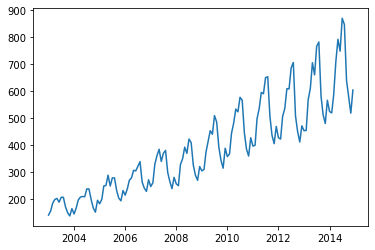

In [11]:
plt.plot(ts);

### Stationary Check

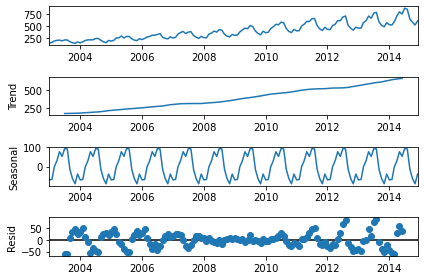

In [12]:
import statsmodels.api as sm
decomposition=sm.tsa.seasonal_decompose(ts,model='additive')
fig=decomposition.plot();

In [13]:
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(ts)
print("p-value", adf_test[1])

p-value 0.9952912415248419


p-value is greater than 0.05 hence series is not stationary.

#### Train Test split

In [14]:
ts.shape

(144, 1)

In [15]:
train=ts[:132]
test=ts[132:]
print(train.shape)
print(test.shape)

(132, 1)
(12, 1)


#### Hyperparameter of ARIMA model p,d,q

* **AR order we get "p"**
* **MA order we get "q"**
* **Integrated order we get "d"**

#### Build ARIMA model

In [16]:
warnings.filterwarnings('ignore')
import statsmodels.api as sm
model=sm.tsa.arima.ARIMA(train,order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

ar.L1       -0.664008
ma.L1        0.961243
sigma2    2363.824312
dtype: float64


#### Prediction

In [17]:
len(train),len(ts)

(132, 144)

In [18]:
pred=model_fit.predict(start=len(train), end=len(ts)-1)
pred

2014-01-01    599.588443
2014-02-01    577.949443
2014-03-01    592.317921
2014-04-01    582.777131
2014-05-01    589.112296
2014-06-01    584.905693
2014-07-01    587.698912
2014-08-01    585.844191
2014-09-01    587.075742
2014-10-01    586.257982
2014-11-01    586.800981
2014-12-01    586.440425
Freq: MS, Name: predicted_mean, dtype: float64

#### Evaluate model

In [19]:
from sklearn.metrics import mean_squared_error
RMSE=np.sqrt(mean_squared_error(test,pred))
print("RMSE", RMSE)

RMSE 144.4494948890788


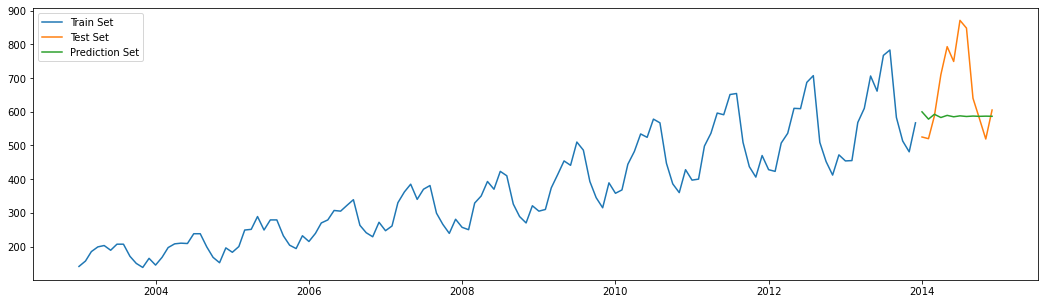

In [20]:
plt.figure(figsize=(18,5))
plt.plot(train, label="Train Set")
plt.plot(test, label="Test Set")
plt.plot(pred, label="Prediction Set")
plt.legend();

#### Hyperparameter selection

In [21]:
import itertools
p=range(0,8)
q=range(0,8)
d=range(0,2)
pdq=list(itertools.product(p,d,q))
len(pdq)

128

In [22]:
len(ts)

144

In [23]:
warnings.filterwarnings('ignore')
rmse=[]
order1=[]
for pdq in pdq:
    try:
        model=sm.tsa.arima.ARIMA(train, order=pdq).fit()
        pred=model.predict(start=len(train), end=len(ts)-1)
        error=np.sqrt(mean_squared_error(pred,test))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [24]:
results=pd.DataFrame(data=rmse, index=order1, columns=['RMSE'])
results

,RMSE
"(0, 0, 0)",321.732876
"(0, 0, 1)",318.240308
"(0, 0, 2)",316.909977
"(0, 0, 3)",316.427838
"(0, 0, 4)",302.525196
...,...
"(7, 1, 3)",84.369154
"(7, 1, 4)",98.886555
"(7, 1, 5)",50.210319
"(7, 1, 6)",46.360959


In [25]:
pd.pivot_table(results, values='RMSE', index=results.index, aggfunc=min).sort_values(by='RMSE', ascending=True)[:5]

,RMSE
"(6, 1, 7)",43.805148
"(7, 1, 6)",46.360959
"(7, 1, 5)",50.210319
"(6, 1, 6)",53.350372
"(4, 1, 7)",56.587551


At p=6, d=1, q=7 the RMSE is 43 which very low compared to any other RMSE. so choosing these value we build our ARIMA model.

In [26]:
model=sm.tsa.arima.ARIMA(train,order=(6, 1, 7))
model_fit = model.fit()
pred=model_fit.predict(start=len(train), end=len(ts)-1)
pred
RMSE=np.sqrt(mean_squared_error(test,pred))
print("RMSE", RMSE)

RMSE 43.80514841542397


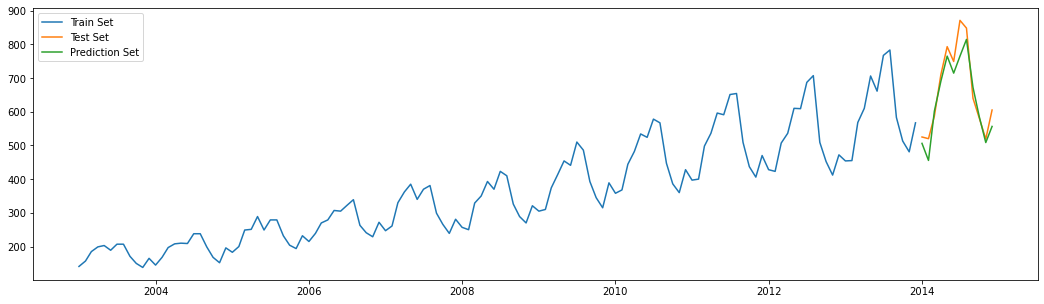

In [27]:
plt.figure(figsize=(18,5))
plt.plot(train, label="Train Set")
plt.plot(test, label="Test Set")
plt.plot(pred, label="Prediction Set")
plt.legend();

**As we can observe from the test & Prediction curve, both are both same shape.. This Model is Good.**